# Reweighting the Complex XY model

See, for example:
- https://link.springer.com/article/10.1007%2FJHEP08%282010%29020

The XY model has the following action
$$S=-\beta \sum_{x} \sum_{\nu=0}^{2} \cos \left(\phi_{x}-\phi_{x+\hat{\nu}}-i \mu \delta_{\nu, 0}\right).$$

The following functions compute the action from data generated by a lattice simulation and implement the complex reweighting method

## Code

In [15]:
import numpy as np
import pandas as pd

def get_action(data, dimensions, beta, mu):
    from mcmctools.utils.lattice import get_neighbour_index
    
    dim_mul = np.cumprod([1] + dimensions)
    lattice_configs = data["Config"].values
    elem_per_site = 1
    n_elems = np.size(lattice_configs, axis=1)

    n_sites = int(np.prod(dimensions))
    N = int(n_elems / n_sites)

    lattice_configs = lattice_configs.reshape(len(data), -1, N)
    

    actions = np.zeros(len(data), dtype=np.complex64)
    for site in range(n_sites):
        neighbour_indices = np.zeros(len(dimensions), dtype=int)
        for dim in range(len(dimensions)):
            neighbour_indices[dim] = get_neighbour_index(n=site, dim=dim, direction=True, mu=0,
                                                         dimensions=dimensions, dim_mul=dim_mul, elem_per_site=elem_per_site)
        
        delta_nu_0 = np.zeros((len(data),3))
        delta_nu_0[:,0] = 1.0
        
        actions += -beta*np.sum(np.cos(lattice_configs[:, site] - lattice_configs[:, neighbour_indices].reshape(len(data),3) - 1j*mu*delta_nu_0), axis=1)

    return actions


def get_phase_factor(data, dimensions, src_params, tar_params):
    #print(np.max((-1.0 * (get_action(data=data, dimensions=dimensions, beta=tar_params["beta"], mu = tar_params["mu"]) -
                          #get_action(data=data, dimensions=dimensions, beta=src_params["beta"], mu = src_params["mu"])))))
    
    return np.exp((-1.0 * (get_action(data=data, dimensions=dimensions, beta=tar_params["beta"], mu = tar_params["mu"]) -
                          get_action(data=data, dimensions=dimensions, beta=src_params["beta"], mu = src_params["mu"]))).astype(np.complex128))


def error_computation_fraction(nominator, denominator, nominator_err, denominator_err):
    real_x = lambda x, y, a, b: a / (a * a + b * b)
    real_y = lambda x, y, a, b: b / (a * a + b * b)
    real_a = lambda x, y, a, b: (-a * a * x + b * b * x - 2 * a * b * y)/ ((a * a + b * b) * (a * a + b * b))
    real_b = lambda x, y, a, b: (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))

    imag_x = lambda x, y, a, b: -1.0 * b / (a * a + b * b)
    imag_y = real_x
    imag_a = lambda x, y, a, b: -1.0 * (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
    imag_b = real_a

    nom_re_err = np.real(nominator_err)
    nom_im_err = np.imag(nominator_err)
    dom_re_err = np.real(denominator_err)
    dom_im_err = np.imag(denominator_err)

    real_error = 0.0
    for err_contr, err in zip([real_x, real_y, real_a, real_b], [nom_re_err, nom_im_err, dom_re_err, dom_im_err]):
        real_error += np.power(err_contr(
            np.real(nominator), np.imag(nominator), np.real(denominator), np.imag(denominator)), 2.0) * np.power(err, 2.0)
    real_error = np.sqrt(real_error)

    imag_error = 0.0
    for err_contr, err in zip([imag_x, imag_y, imag_a, imag_b], [nom_re_err, nom_im_err, dom_re_err, dom_im_err]):
        imag_error += np.power(err_contr(
            np.real(nominator), np.imag(nominator), np.real(denominator), np.imag(denominator)), 2.0) * np.power(err, 2.0)
    imag_error = np.sqrt(imag_error)
    
    return real_error + 1.0j * imag_error


def reweight(data, phase_factor, observable, tar_params, dimensions):
    from scipy import stats
    nominator = observable(x=data, params=tar_params, dimensions=dimensions).astype(np.complex128) * phase_factor
    mask = ~np.any([np.real(nominator) < -1e8, np.real(nominator) > 1e8, np.imag(nominator) < -1e8, np.imag(nominator) > 1e8], axis=0)
    
    nominator_err = stats.sem(np.real(nominator[mask])) + 1.0j * stats.sem(np.imag(nominator[mask]))
    phase_factor_err = stats.sem(np.real(phase_factor[mask])) + 1.0j * stats.sem(np.imag(phase_factor[mask]))
    
    nominator = nominator[mask].mean()
    phase_factor = phase_factor[mask].mean()
    
    if np.sum(~mask) > 100000:
        print("More than 100000 unsuable samples for computation of observables")

    return nominator / phase_factor, error_computation_fraction(
        nominator=nominator, denominator=phase_factor, nominator_err=nominator_err, denominator_err=phase_factor_err)


def action_density(x, params, dimensions):
    return get_action(x, dimensions, params["beta"], params["mu"])/np.prod(dimensions)


def reweight_results_mulitple_targets(data, src_params, observables, tar_params, dimensions): #format of src_param = {"beta": h, "mu": mu}
    from scipy import stats
    
    results = {"re_phase_factor": [], "re_phase_factor_err": [], "src_beta": [], "src_mu": []}
    results = {"tar_beta": tar_params["beta"], "tar_mu": tar_params["mu"],
               **results, **{"re_" + key: [] for key in list(observables.keys())},
               **{"re_" + key + "_err": [] for key in list(observables.keys())}}
    
    src_param = src_params
    
    from tqdm import tqdm
    for beta, mu in tqdm(zip(tar_params["beta"], tar_params["mu"])):
        tar_param = {"beta": beta, "mu": mu}
        phase_factor = get_phase_factor(data=data, dimensions=dimensions, src_params=src_param, tar_params=tar_param)
        mask = ~np.any([np.real(phase_factor) < -1e8, np.real(phase_factor) > 1e8, np.imag(phase_factor) < -1e8, np.imag(phase_factor) > 1e8], axis=0)
        
        if np.sum(~mask) > 5000:
            print("More than 5000 unsuable samples for computation of phase factor")
        
        results["re_phase_factor"].append(phase_factor[mask].mean())
        results["re_phase_factor_err"].append(stats.sem(np.real(phase_factor[mask])) + 1.0j * stats.sem(np.imag(phase_factor[mask])))
        results["src_beta"].append(src_param["beta"])
        results["src_mu"].append(src_param["mu"])
        
        for key, observable in observables.items():
            try:
                re_observable, re_observable_err = reweight(
                    data=data.iloc[mask], phase_factor=phase_factor[mask], observable=observable, tar_params=tar_param, dimensions=dimensions)
                
            except:
                re_observable = "fail"
                re_observable_err = "fail"
                    
            results["re_" + key].append(re_observable)
            results["re_" + key + "_err"].append(re_observable_err)
            
            
    results = pd.DataFrame(results)
    return results


def get_M(src_data, tar_data, src_param, tar_param, N, observables, dimensions): # src_data, tar_data, , observables, dimensions
    
    src_vector = np.array(list(src_param.values()))
    tar_vector = np.array(list(tar_param.values()))
    
    diff_vector = tar_vector - src_vector
    step_vector = diff_vector/N
    
    num_params = len(src_vector)
    
    steps_array = np.zeros((N+1,num_params))
    
    for j in range(N+1):
        steps_array[j,:] = src_vector + j*step_vector
    
    param_names = list(src_param.keys())
    inter_tar_params = {param_names[0]: steps_array[:,0], param_names[1]: steps_array[:,1]}
    
    obs_from_src = reweight_results_mulitple_targets(src_data, src_param, observables, inter_tar_params, dimensions)
    obs_from_tar = reweight_results_mulitple_targets(tar_data, tar_param, observables, inter_tar_params, dimensions)
    
    diff = np.nan_to_num(np.array(obs_from_tar["re_E"] - obs_from_src["re_E"]).real)
    
    print("obs from target:", np.array(obs_from_tar["re_E"]).real)
    print("obs from source:", np.array(obs_from_src["re_E"]).real)
    
    print("difference:", diff)
                                               
    M = np.sqrt(np.sum(diff**2))
    
    return M


# Examples for arguments:
# params = {"beta": [0.7, ...], "mu": [0.0, 0.1, ...]}
# dimensions = [2,2,2]
# data_sets is a list of the data for each parameter configuration -> data_sets = [data_0, data_1, ...]

def do_stepwise_reweighting_E(data_sets, params, N, dimensions): 
    
    observables = {"E":  action_density}
    
    num_configs = len(params["mu"])
    
    global M_values
    
    M_values = np.zeros(num_configs-1)
    
    for i in range(num_configs-1):
        
        src_data = data_sets[i]
        src_beta = params["beta"][i]
        src_mu = params["mu"][i]
        
        src_param = {"beta": src_beta, "mu": src_mu}
        
        tar_data = data_sets[i+1]
        tar_beta = params["beta"][i+1]
        tar_mu = params["mu"][i+1]
        
        tar_param = {"beta": tar_beta, "mu": tar_mu}
        
        try:
            M_values[i] = get_M(src_data, tar_data, src_param, tar_param, N, observables, dimensions)
        
        except:
            M_values[i] = None
        
    #return np.array(M_values)
    
    
def get_data_sets(data, params, num_samples):
    num_params = len(params["mu"])
    data_sets = []
    for i in range(num_params):
        data_sets.append(data.iloc[i*num_samples:(i+1)*num_samples, :])
    return data_sets

## Results

### 1. Load data

In [24]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to examples/ directory as project root directory
    import os
    os.chdir("../ComplexXYModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./python_scripts")

In [26]:
from mcmctools.mcmc.evaluation_module import EvaluationModule
from mcmctools.utils.utils import linspace_rp_intervals
evaluation_module = EvaluationModule(sim_base_dir="./", rel_data_dir="data/ComplexXYModelComplexLangevin/",
                                     rel_results_dir="results/ComplexXYModelComplexLangevin/",
                                     running_parameter_kind=None,
                                     running_parameter="mu",
                                     rp_values=linspace_rp_intervals(0.0, 3.0, 13))

In [27]:
expectation_values = evaluation_module.load_expectation_values()
expectation_values

val,Estimate,Error,Estimate,Error,Estimate,Error
quantity,Energy,Energy,Mean,Mean,Mu,Mu
mu,,,,,,
0.000000,-0.154323+0.000000j,0.000273+0.000000j,3.141235+0.000000j,0.001506+0.000000j,0.00+0.00j,0.0+0.0j
0.250000,-0.179061+0.000404j,0.000326+0.000232j,3.168276+0.000000j,0.001477+0.000000j,0.25+0.00j,0.0+0.0j
0.500000,-0.202903+0.001185j,0.000399+0.000256j,3.075432+0.000000j,0.001590+0.000000j,0.50+0.00j,0.0+0.0j
0.750000,-0.225389+0.001259j,0.000406+0.000321j,3.114349+0.000000j,0.001814+0.000000j,0.75+0.00j,0.0+0.0j
1.000000,-0.283256-0.002006j,0.000454+0.000356j,3.146248+0.000000j,0.002661+0.000000j,1.00+0.00j,0.0+0.0j
1.250000,-0.384324-0.002531j,0.000611+0.000429j,3.128695+0.000000j,0.002547+0.000000j,1.25+0.00j,0.0+0.0j
1.500000,-0.497397+0.002436j,0.000746+0.000470j,3.074969+0.000000j,0.001794+0.000000j,1.50+0.00j,0.0+0.0j
1.750000,-0.801714-0.003408j,0.000578+0.000375j,3.259556+0.000000j,0.004066+0.000000j,1.75+0.00j,0.0+0.0j


In [28]:
data = evaluation_module.load_data()
data

quantity                         Energy                Mean   Mu  \
elem                                                               
mu       sample_num                                                
0.000000 0          -0.364597+0.000000j  3.240679+0.000000j  0.0   
         1          -0.362472+0.000000j  3.248713+0.000000j  0.0   
         2          -0.354935+0.000000j  3.253485+0.000000j  0.0   
         3          -0.350651+0.000000j  3.299618+0.000000j  0.0   
         4          -0.350752+0.000000j  3.203287+0.000000j  0.0   
...                                 ...                 ...  ...   
3.000000 9995       -3.079107-0.010623j  1.370372+0.000000j  3.0   
         9996       -3.061031-0.008912j  1.433878+0.000000j  3.0   
         9997       -3.065042-0.005854j  1.421210+0.000000j  3.0   
         9998       -3.043072-0.006555j  1.440030+0.000000j  3.0   
         9999       -3.048371-0.004628j  1.446376+0.000000j  3.0   

quantity                         Config                      \
elem                                  0                   1   
mu       sample_num                                           
0.000000 0           4.763678+0.000000j  5.762644+0.000000j   
         1           4.743461+0.000000j  5.763051+0.000000j   
         2           4.608900+0.000000j  5.646702+0.000000j   
         3           4.725702+0.000000j  5.797456+0.000000j   
         4           4.629159+0.000000j  5.876758+0.000000j   
...                                 ...                 ...   
3.000000 9995        0.779448-0.011270j  0.196162+0.010162j   
         9996        0.696177-0.012398j  0.563361+0.010925j   
         9997        0.698663-0.011666j  0.433559+0.008242j   
         9998        0.822426-0.011099j  0.605514+0.001283j   
         9999        1.034035-0.015839j  0.344968+0.003112j   

quantity                                                     \
elem                                  2                   3   
mu       sample_num                                           
0.000000 0           1.041448+0.000000j  5.734780+0.000000j   
         1           1.066874+0.000000j  5.630869+0.000000j   
         2           1.177398+0.000000j  5.552294+0.000000j   
         3           1.378001+0.000000j  5.802820+0.000000j   
         4           1.431336+0.000000j  5.868048+0.000000j   
...                                 ...                 ...   
3.000000 9995        0.127577+0.018919j  6.059838-0.087809j   
         9996        6.277647+0.015718j  6.200756-0.101525j   
         9997        6.265726+0.014523j  6.253840-0.111858j   
         9998        6.211923+0.017110j  0.090385-0.115940j   
         9999        6.091762+0.016587j  6.217326-0.118718j   

quantity                                                     \
elem                                  4                   5   
mu       sample_num                                           
0.000000 0           0.786183+0.000000j  6.221656+0.000000j   
         1           0.864662+0.000000j  0.062776+0.000000j   
         2           1.005271+0.000000j  0.097834+0.000000j   
         3           1.183896+0.000000j  6.091542+0.000000j   
         4           0.876221+0.000000j  6.140535+0.000000j   
...                                 ...                 ...   
3.000000 9995        0.950871-0.018030j  0.994176+0.056352j   
         9996        0.965710+0.002511j  0.998699+0.053031j   
         9997        0.986705+0.018611j  1.036890+0.050316j   
         9998        0.929378+0.028259j  1.069793+0.048436j   
         9999        0.818448+0.035698j  1.073742+0.047074j   

quantity                                 ...                      \
elem                                  6  ...                 502   
mu       sample_num                      ...                       
0.000000 0           0.904627+0.000000j  ...  1.046210+0.000000j   
         1           0.901981+0.000000j  ...  1.014620+0.000000j   
         2           0.901858+0.000000j  ...  1.152627+0.0

In [29]:
mu_values = np.linspace(0.0,3.0,13)
mu_values

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  ])

### 2. Create params object, set other variables, and get data_sets list

In [30]:
num_samples = 10000
mu_values = list(np.array(data["Mu"])[::num_samples])
beta = 0.3
beta_values = [beta for _ in range(len(mu_values))]
params = {"beta": beta_values, "mu": mu_values}
print(params)


{'beta': [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], 'mu': [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]}


In [31]:
dimensions = [8,8,8]
num_steps = 5
print(len(mu_values)*num_samples)

data_sets = get_data_sets(data, params, num_samples)

130000


### 3. Return M_values

In [32]:
do_stepwise_reweighting_E(data_sets, params, num_steps, dimensions)
#np.savetxt("M_values.txt", M_values)
M_values

6it [00:20,  3.49s/it]
6it [00:33,  5.54s/it]


obs from target: [-0.02439201 -0.04202854  1.11279508  0.66967789  0.52692707 -0.17906093]
obs from source: [-0.15432263 -0.15445422 -0.15486082 -0.15558752 -0.15676074 -0.15877591]
difference: [ 0.12993062  0.11242568  1.26765591  0.82526541  0.68368782 -0.02028502]


6it [00:27,  4.57s/it]
6it [00:31,  5.22s/it]


obs from target: [-0.01722814 -0.80502464  0.44998698  0.01680854 -0.25344506 -0.20290348]
obs from source: [-0.17906093 -0.2163789  -0.42223483 -0.45480919 -0.4152387  -0.29703927]
difference: [ 0.16183279 -0.58864574  0.87222181  0.47161773  0.16179364  0.09413579]


6it [00:30,  5.11s/it]
6it [00:27,  4.62s/it]


obs from target: [-0.02224214  0.00101829  0.02496914  0.07453791  0.28622505 -0.22538943]
obs from source: [-0.20290348 -0.52460638 -0.5125551  -0.41444877 -0.27522631 -0.41878805]
difference: [0.18066134 0.52562467 0.53752424 0.48898669 0.56145136 0.19339862]


6it [00:30,  5.06s/it]
6it [00:30,  5.10s/it]


obs from target: [-0.06519607 -0.06657382 -0.03109503  0.19523035  0.24966322 -0.28325561]
obs from source: [-0.22538943 -0.95863742 -0.56169286 -0.49480304 -0.44571304 -0.44235933]
difference: [0.16019336 0.89206361 0.53059782 0.69003338 0.69537627 0.15910372]


6it [00:25,  4.19s/it]
6it [00:26,  4.40s/it]


obs from target: [-0.24762661  0.0097415  -0.00548428 -0.00994757  0.24446406 -0.38432357]
obs from source: [-0.28325561 -0.67719186 -0.71885376 -0.53669729 -0.36487857 -0.30355181]
difference: [ 0.035629    0.68693336  0.71336948  0.52674973  0.60934262 -0.08077175]


4it [00:17,  4.46s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:24,  4.05s/it]


More than 5000 unsuable samples for computation of phase factor


6it [00:25,  4.27s/it]


obs from target: [-0.54856765 -0.09449989 -0.20433513  0.08748023 -0.01716583 -0.497397  ]
obs from source: [-0.38432357 -0.51132973 -0.88415914 -0.42611654 -0.40876704 -0.40798697]
difference: [-0.16424408  0.41682984  0.67982401  0.51359677  0.39160121 -0.08941004]


4it [00:16,  4.00s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:20,  3.89s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:23,  3.84s/it]


More than 5000 unsuable samples for computation of phase factor


6it [00:26,  4.39s/it]


obs from target: [-0.38495466 -0.38650694 -0.39009607 -0.39104874 -0.26397818 -0.80171425]
obs from source: [-0.497397   -0.8453011  -0.53494716 -0.39250037 -0.43678445 -0.35836178]
difference: [ 0.11244235  0.45879417  0.14485109  0.00145163  0.17280627 -0.44335247]


3it [00:11,  3.58s/it]

More than 5000 unsuable samples for computation of phase factor


4it [00:14,  3.39s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:18,  3.73s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:22,  3.82s/it]


More than 5000 unsuable samples for computation of phase factor


6it [00:25,  4.29s/it]


obs from target: [-0.54307014 -0.55491942 -0.57078179 -0.58827473 -0.62162071 -1.10197567]
obs from source: [-0.80171425 -0.84420037 -0.5553762  -0.27225865 -0.49114931 -0.45154484]
difference: [ 0.25864412  0.28928095 -0.01540559 -0.31601608 -0.1304714  -0.65043084]


1it [00:04,  4.19s/it]

More than 5000 unsuable samples for computation of phase factor


3it [00:10,  3.27s/it]

More than 5000 unsuable samples for computation of phase factor


<ipython-input-15-c34e84d75f2a>:113: RuntimeWarning: Mean of empty slice.
  results["re_phase_factor"].append(phase_factor[mask].mean())
/home/hosak/miniconda3/envs/lattice/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hosak/miniconda3/envs/lattice/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hosak/miniconda3/envs/lattice/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/hosak/miniconda3/envs/lattice/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
4it [00:13,  3.13s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:16,  3.02s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:19,  3.18s/it]


More than 5000 unsuable samples for computation of phase factor


6it [00:25,  4.19s/it]
2it [00:06,  3.24s/it]

More than 5000 unsuable samples for computation of phase factor


3it [00:09,  3.03s/it]

More than 5000 unsuable samples for computation of phase factor


4it [00:12,  2.91s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:14,  2.84s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:17,  2.93s/it]


More than 5000 unsuable samples for computation of phase factor


6it [00:25,  4.31s/it]
2it [00:07,  3.55s/it]

More than 5000 unsuable samples for computation of phase factor


3it [00:10,  3.27s/it]

More than 5000 unsuable samples for computation of phase factor


4it [00:13,  3.12s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:16,  3.03s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:19,  3.20s/it]


More than 5000 unsuable samples for computation of phase factor


0it [00:00, ?it/s]<ipython-input-15-c34e84d75f2a>:44: RuntimeWarning: divide by zero encountered in double_scalars
  real_a = lambda x, y, a, b: (-a * a * x + b * b * x - 2 * a * b * y)/ ((a * a + b * b) * (a * a + b * b))
<ipython-input-15-c34e84d75f2a>:45: RuntimeWarning: divide by zero encountered in double_scalars
  real_b = lambda x, y, a, b: (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
<ipython-input-15-c34e84d75f2a>:49: RuntimeWarning: divide by zero encountered in double_scalars
  imag_a = lambda x, y, a, b: -1.0 * (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
6it [00:25,  4.18s/it]
2it [00:06,  3.26s/it]

More than 5000 unsuable samples for computation of phase factor


3it [00:09,  2.95s/it]

More than 5000 unsuable samples for computation of phase factor


4it [00:12,  2.87s/it]

More than 5000 unsuable samples for computation of phase factor


5it [00:14,  2.76s/it]

More than 5000 unsuable samples for computation of phase factor


6it [00:17,  2.88s/it]


More than 5000 unsuable samples for computation of phase factor


0it [00:00, ?it/s]<ipython-input-15-c34e84d75f2a>:44: RuntimeWarning: invalid value encountered in double_scalars
  real_a = lambda x, y, a, b: (-a * a * x + b * b * x - 2 * a * b * y)/ ((a * a + b * b) * (a * a + b * b))
<ipython-input-15-c34e84d75f2a>:45: RuntimeWarning: invalid value encountered in double_scalars
  real_b = lambda x, y, a, b: (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
<ipython-input-15-c34e84d75f2a>:49: RuntimeWarning: invalid value encountered in double_scalars
  imag_a = lambda x, y, a, b: -1.0 * (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
6it [00:23,  3.94s/it]


array([1.66894473, 1.1793755 , 1.09068362, 1.444985  , 1.27958222,
       1.04307776, 0.68596117, 0.83112382,        nan,        nan,
              nan,        nan])

### 4. Plot M_values

(0.0, 3.0)

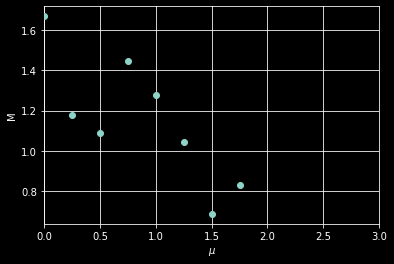

In [36]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.scatter(mu_values[:-1], M_values[:], zorder=3)
plt.xlabel("$\mu$")
plt.ylabel("M")
plt.grid(zorder=0)
plt.xlim(0,3.0)


In [34]:
M_values

array([1.66894473, 1.1793755 , 1.09068362, 1.444985  , 1.27958222,
       1.04307776, 0.68596117, 0.83112382,        nan,        nan,
              nan,        nan])

In [35]:
mu_values

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]

In [19]:
np.sqrt(0.2)

0.4472135954999579